# Introduction
This project was created for the [Neural Networks and Deep Learning 2017](https://sites.google.com/a/cs.uni.wroc.pl/jch/teaching/neural-networks-fall-17) class taught at the University of Wrocław. This is attempt to [reproducibility challenge](http://www.cs.mcgill.ca/~jpineau/ICLR2018-ReproducibilityChallenge.html) of [Learning Wasserstein Embeddings](https://openreview.net/forum?id=SJyEH91A-) papers published on [ICLR 2018 Conference](https://iclr.cc/).

This is my implementation based on the researchers paper. I used [POT toolbox](https://github.com/rflamary/POT) to compute true Wasserstein distance between images.

Borys Dyczko ([shajen](https://github.com/shajen))

# About project
What is it [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric)? Wasserstein metric is distance function defined between probability distributions. In this project, images are used as a special case of a probability distribution. To make it easier, we can think about Wasserstein metric as a function of similarity of two images. For example, the distance between two cats images should be near zero, while the distance between cat and human face images should be much bigger. 

The main goal is to build and train [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network) that contains two parts: encoder and decoder. The encoder transforms images to a vector of fifty values. The decoder transform vector to original image. The distance between images is difference between two vectors. The decoder is used to present graphical experiments for example barycenter, images interpolation.

# Problems
The researchers proposed to use loss criterion as sum of [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) and [KLDiv](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) as below:

$loss = MSELoss(encoder) + \lambda * KLDivLoss(decoder)$ 

with $\lambda > 0$.

I encountered a problem while training network. It was difficult to find proper $\lambda$. I could not find information about $\lambda$ value. In all attempts decoder could not learn properly, however, encoder worked well. I decided to use MSE in both parts and sum it up without factor.  I decided to use MSE in both parts and sum it up without factor. So in my implementation, loss criterion looks as below:

$loss = MSELoss(encoder) + MSELoss(decoder)$.

This is the one small part that I could not reproduce.

The second difficulty was that POT toolbox uses double representation and MNIST uses float representation. I spent a few hours debugging why `ot.emd2()` return zero or nan. Just use `.double()`. I hope this will help you save time.

# MNIST results
First dataset was [MNIST](https://github.com/datapythonista/mnist). Training took about 2 hours, just like in the original paper. I received MSE 0.35 which is similar or even a bit better. Computed barycenters of all classes using L2 and DWE looks similar like in the original paper. Graphs with results are at the very bottom.

# Doodle results
Second dataset was [doodle](https://quickdraw.withgoogle.com/data). This dataset was more complicated and images are more diverse.

The first attempt with learning rate 0.0005 took 2 hours to train. I chose two random faces to make interpolation image between them. The results are fuzzy and a bit worse than ICLR researchers results but you can still consider them to be correct. I tried to train few times on different random dataset but the results were always the same.

I made second attempt with learning rate 0.0001 but only to see what will happen. Training took 2 days and the results look a bit better than above.

Graphs with results are at the very bottom.

# Workstation
All computations were carried out on a machine equipped with quad-core CPU, 16GB RAM, and Nvidia Tesla K80.

# Acknowledgments
The authors thank Google for GCE Credits awarded through [Google Cloud Platform Education Grants](https://cloud.google.com/edu/) to the Neural Networks and Deep Learning course and to this project.

# Licensed
This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see [GPL](http://www.gnu.org/licenses/).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import re
import os
import ot
import datetime
import sys
import collections

from random import randint
from common.plotting import plot_mat

import numpy as np

import logging
logging.getLogger("PIL").setLevel(logging.INFO)

import torch 
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

os.environ['TORCH_MODEL_ZOO'] =  os.environ['PYTORCH_DATA_PATH']

In [3]:
def load_torch_config(filename):
    return torch.load('%s/%s' % (DST_CONFIG_DIR, filename))

def save_torch_config(data, filename):
    if not os.path.exists(DST_CONFIG_DIR):
        os.mkdir(DST_CONFIG_DIR)
    return torch.save(data, '%s/%s' % (DST_CONFIG_DIR, filename))

def load_torch_big_data(filename, samples):
    return torch.load('%s/%d/%s' % (DST_BIG_DATA_DIR, samples, filename))

def save_torch_big_data(data, filename, samples):
    if not os.path.exists(DST_BIG_DATA_DIR):
        os.mkdir(DST_BIG_DATA_DIR)
    if not os.path.exists('%s/%d' % (DST_BIG_DATA_DIR, samples)):
        os.mkdir('%s/%d' % (DST_BIG_DATA_DIR, samples))
    return torch.save(data, '%s/%d/%s' % (DST_BIG_DATA_DIR, samples, filename))

def to_np(x):
    if isinstance(x, Variable):
        x = x.data
    return x.cpu().numpy()

def to_variable(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return Variable(x, **kwargs)

def log(text):
    if not DEBUG:
        return None
    if not os.path.exists(DST_CONFIG_DIR):
        os.mkdir(DST_CONFIG_DIR)
    text = '%s | %s' % (datetime.datetime.now(), text)
    with open('%s/%s' % (DST_CONFIG_DIR, LOG_FILE), 'a') as file:
        file.write(text + '\n')
        file.flush()
    print(text)
    sys.stdout.flush()

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view((x.size(0), ) + self.shape)

In [4]:
def ground_matrix(n):
    x = []
    for i in range(n):
        for j in range(n):
            x.append([i, j])
    x = np.array(x)
    M = ot.dist(x, x, 'sqeuclidean')
    return M

def sqeuclidean_wasserstein_distance(x, y):
    x = to_np(x)
    y = to_np(y)
    M = ground_matrix(x.shape[1])
    x = x.reshape(x.shape[0], -1)
    y = y.reshape(y.shape[0], -1)
    return torch.Tensor([ot.emd2(x[i], y[i], M) for i in range(0, x.shape[0])])

def barycenter(x):
    x = x.double()
    x = to_np(x)
    M = ground_matrix(x.shape[1])
    reg = 1e-2
    x = x.reshape(x.shape[0], -1)
    x = numpy.swapaxes(x, 0, 1)
    return torch.Tensor([ot.barycenter(x, M, reg)])

In [5]:
def load_mnist(samples):
    log('start reading mnist data')
    
    try:
        log('read images, labels, distances from files')
        images = load_torch_big_data('images.pt', samples)
        labels = load_torch_big_data('labels.pt', samples)
        distances = load_torch_big_data('distances.pt', samples)
    except Exception as e:
        log('error, calucalting new data')
        data_path = os.environ.get('PYTORCH_DATA_PATH', '../data')

        dataset = torchvision.datasets.MNIST(data_path, train=True, download=True)
        imagesList = dataset.train_data
        imagesList = imagesList.squeeze(1).double()
        imagesList = imagesList.div(imagesList.sum(1).sum(1).unsqueeze(1).unsqueeze(1))
        labelsList = dataset.train_labels

        indexes = set()
        while len(indexes) < samples:
            indexes.add((randint(0, imagesList.size(0)-1), randint(0, imagesList.size(0)-1)))
        indexes = [j for i in list(indexes) for j in i]

        images = torch.index_select(imagesList, 0, torch.LongTensor(indexes))
        labels = torch.index_select(labelsList, 0, torch.LongTensor(indexes))
        images = images.view(-1, 2, images.size(1), images.size(2))
        labels = labels.view(-1, 2)
        distances = sqeuclidean_wasserstein_distance(images[:, 0], images[:, 1])

        images = images.float()
        distances = distances.float()

        save_torch_big_data(images, 'images.pt', samples)
        save_torch_big_data(labels, 'labels.pt', samples)
        save_torch_big_data(distances, 'distances.pt', samples)

    log('%d samples count' % images.size(0))
    log('distances sum: %.2f' % distances.sum())
    log('distances min: %.2f' % distances.min())
    log('distances max: %.2f' % distances.max())

    n_train = int(images.size(0) * 0.7)
    n_valid = int(images.size(0) * 0.9)
    train_images = images[:n_train]
    train_labels = labels[:n_train]
    train_distances = distances[:n_train]

    valid_images = images[n_train:n_valid]
    valid_labels = labels[n_train:n_valid]
    valid_distances = distances[n_train:n_valid]

    test_images = images[n_valid:]
    test_labels = labels[n_valid:]
    test_distances = distances[n_valid:]

    log('finish loading')
    return (train_images, train_labels, train_distances, valid_images, valid_labels, valid_distances, test_images, test_labels, test_distances)

In [6]:
def randIndex(classes):
    c = randint(0, len(classes) - 1)
    s = sum(x.size(0) for x in classes[:c])
    i = randint(0, classes[c].size(0) - 1)
    return s + i
    
def load_doodle(samples):
    log('start reading doodle data')
    
    try:
        log('read images, labels, distances from files')
        images = load_torch_big_data('images.pt', samples)
        labels = load_torch_big_data('labels.pt', samples)
        distances = load_torch_big_data('distances.pt', samples)
    except Exception as e:
        log('error, calucalting new data')
        data_path = os.environ.get('PYTORCH_DATA_PATH', '../data')

        catsImages = torch.from_numpy(np.load('doodle/cat.npy')).view(-1, 28, 28)
        crabsImages = torch.from_numpy(np.load('doodle/crab.npy')).view(-1, 28, 28)
        facesImages = torch.from_numpy(np.load('doodle/face.npy')).view(-1, 28, 28)
        mnistImages = torchvision.datasets.MNIST(data_path, train=True, download=True).train_data

        catsImages = catsImages.double()
        crabsImages = crabsImages.double()
        facesImages = facesImages.double()
        mnistImages = mnistImages.squeeze(1).double()
        
        catsImages = catsImages.div(catsImages.sum(1).sum(1).unsqueeze(1).unsqueeze(1))
        crabsImages = crabsImages.div(crabsImages.sum(1).sum(1).unsqueeze(1).unsqueeze(1))
        facesImages = facesImages.div(facesImages.sum(1).sum(1).unsqueeze(1).unsqueeze(1))
        mnistImages = mnistImages.div(mnistImages.sum(1).sum(1).unsqueeze(1).unsqueeze(1))               
        
        imagesList = torch.cat((mnistImages, catsImages, crabsImages, facesImages), 0)
        labelsList = [0] * catsImages.size(0) + [1] * crabsImages.size(0) + [2] * facesImages.size(0) + [3] * mnistImages.size(0)
        labelsList = torch.Tensor(labelsList).int()
               
        indexes = set()
        while len(indexes) < samples:
            i1 = randIndex([catsImages, crabsImages, facesImages, mnistImages])
            i2 = randIndex([catsImages, crabsImages, facesImages, mnistImages])
            indexes.add((i1, i2))
        indexes = [j for i in list(indexes) for j in i]

        images = torch.index_select(imagesList, 0, torch.LongTensor(indexes))
        labels = torch.index_select(labelsList, 0, torch.LongTensor(indexes))
        images = images.view(-1, 2, images.size(1), images.size(2))
        labels = labels.view(-1, 2)
        distances = sqeuclidean_wasserstein_distance(images[:, 0], images[:, 1])

        images = images.float()
        distances = distances.float()

        save_torch_big_data(images, 'images.pt', samples)
        save_torch_big_data(labels, 'labels.pt', samples)
        save_torch_big_data(distances, 'distances.pt', samples)
        
    log('%d samples count' % images.size(0))
    log('distances sum: %.2f' % distances.sum())
    log('distances min: %.2f' % distances.min())
    log('distances max: %.2f' % distances.max())

    n_train = int(images.size(0) * 0.7)
    n_valid = int(images.size(0) * 0.9)
    train_images = images[:n_train]
    train_labels = labels[:n_train]
    train_distances = distances[:n_train]

    valid_images = images[n_train:n_valid]
    valid_labels = labels[n_train:n_valid]
    valid_distances = distances[n_train:n_valid]

    test_images = images[n_valid:]
    test_labels = labels[n_valid:]
    test_distances = distances[n_valid:]

    log('finish loading')
    return (train_images, train_labels, train_distances, valid_images, valid_labels, valid_distances, test_images, test_labels, test_distances)

In [7]:
def printMatrixDistancesLabels(distances, labels, classesCount):
    samples = distances.size(0)
    distances_matrix_sum = np.zeros((classesCount, classesCount))
    distances_matrix_count = np.zeros((classesCount, classesCount))

    for i in range(samples):
        l1 = max(labels[i])
        l2 = min(labels[i])
        distances_matrix_sum[l1][l2] += distances[i]
        distances_matrix_count[l1][l2] += 1

    np.set_printoptions(precision=2)
    log('\n' + str(distances_matrix_sum))
    log('\n' + str(distances_matrix_count))
    log('\n' + str(distances_matrix_sum / distances_matrix_count))

#     from common.plotting import plot_mat
#     for i in range(10):
#         d = sqeuclidean_wasserstein_distance(images[i][0].unsqueeze(0), images[i][1].unsqueeze(0))[0]
#         lol = to_np(images[i])
#         lol = np.array([lol[0], lol[1]])
#         lol = np.expand_dims(lol, axis=1)
#         plot_mat(lol, cmap='gray')
#         plt.title("Distance: %.2f" % d)
#         show()

In [8]:
def compute_error_rate(model, allX, allY, batch_size):
    i = 0
    mse = 0.0
    while i < allX.size(0):
        x = Variable(allX[i:i+batch_size])
        y = Variable(allY[i:i+batch_size])
        if CUDA:
            x = x.cuda()
            y = y.cuda()
        (outputs, _) = model(x)
        diff = (outputs - y).data
        mse = mse + torch.sum(diff ** 2)
        i = i + batch_size
    return mse / allX.size(0)

def compute_prediction(model, allX, batch_size):
    i = 0
    y = torch.FloatTensor()
    if CUDA:
        y = y.cuda()
    while i < allX.size(0):
        x = Variable(allX[i:i+batch_size])
        if CUDA:
            x = x.cuda()
        y = torch.cat((y, model(x)[0].data), 0)
        i += batch_size
    return y

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 20, kernel_size=3, padding=0),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(20, 10, kernel_size=3, padding=0),
                nn.ReLU()),
            nn.Sequential(
                nn.Conv2d(10, 5, kernel_size=5, padding=0),
                nn.ReLU()),
            Reshape(-1),
            nn.Sequential(
                nn.Linear(2000, 100),
                nn.ReLU()),
            nn.Sequential(
                nn.Linear(100, 50),
                nn.ReLU())
        )
        
        self.decoder = nn.Sequential(
            nn.Sequential(
                nn.Linear(50, 100),
                nn.ReLU()),
            nn.Sequential(
                nn.Linear(100, 5 * 20 * 20),
                nn.ReLU()),
            Reshape(5, 20, 20),
            nn.Sequential(
                nn.ConvTranspose2d(5, 10, kernel_size=5, padding=0),
                nn.ReLU()),
            nn.Sequential(
                nn.ConvTranspose2d(10, 20, kernel_size=3, padding=0),
                nn.ReLU()),
            nn.Sequential(
                nn.ConvTranspose2d(20, 1, kernel_size=3, padding=0),
                nn.ReLU()),
            Reshape(28 * 28),
            nn.Softmax(),
            Reshape(1, 28, 28)
        )
        
    def forward(self, data):
        data1 = data[:, 0].unsqueeze(1)
        encoder1 = self.encoder(data1)
        decoder1 = self.decoder(encoder1)
        
        data2 = data[:, 1].unsqueeze(1)
        encoder2 = self.encoder(data2)
        decoder2 = self.decoder(encoder2)
            
        encoder_difference = encoder1 - encoder2
        encoder_factor = torch.torch.matmul(encoder_difference, encoder_difference.transpose(0, 1)).diag()
        
        return (encoder_factor, (decoder1, decoder2))
      
def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))
        m.bias.data.zero_()
            
def loadModel(model):
    try:
        log('load model')
        model.load_state_dict(load_torch_config('cnn.pkl'))
        log('load model finished')
    except Exception as e:
        print(e)
        log('load model error')

def trainModel(model, train_images, train_distances, valid_images, valid_distances, learning_rate, samples, batch_size, kl_weight, restore):
    log('start training')

    epoch = 0
    num_epochs = 1
    patience_expansion = 1.5
    best_value_error = 1000000.0
    best_params = None

    mse_criterion = nn.MSELoss()
    #kl_criterion = nn.KLDivLoss(size_average=False)
    #kl_criterion = nn.KLDivLoss()
    kl_criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if restore:
        try:
            log('restore training data')
            model.load_state_dict(load_torch_config('cnn.pkl'))
            optimizer.load_state_dict(load_torch_config('optimizer.pkl'))
            e = load_torch_config('epoch.pkl')
            epoch = e[0]
            num_epochs = e[1]
            log('restore training data finished')
        except:
            log('restore training data error')
    
    try:
        while epoch < num_epochs:
            epoch += 1
            i = 0
            while i < train_images.size(0):
                optimizer.zero_grad()
                x = Variable(train_images[i:i+batch_size])
                y = Variable(train_distances[i:i+batch_size])
                if CUDA:
                    x = x.cuda()
                    y = y.cuda()
                (distances_outputs, (images1_outputs, images2_outputs)) = model(x)
                x1 = x[:, 0].unsqueeze(1)
                x2 = x[:, 1].unsqueeze(1)
                
                loss1 = mse_criterion(distances_outputs, y)
                loss2 = kl_criterion(images1_outputs, x1)
                loss3 = kl_criterion(images2_outputs, x2)
                loss = loss1 + kl_weight * (loss2 + loss3)
                
                loss.backward()
                optimizer.step()
                i = i + batch_size

            value_error = compute_error_rate(model, valid_images, valid_distances, batch_size)
            if (value_error < best_value_error):
                best_value_error = value_error
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_params = [p.clone().cpu() for p in model.parameters()]

            log('epoch [%d/%d]' % (epoch, num_epochs))
            log('train set errors: %.2f' % torch.abs(loss).data[0])
            log('validation set errors: %.2f' % value_error)
            log('')

            save_torch_config(model.state_dict(), 'cnn.pkl')
            save_torch_config(optimizer.state_dict(), 'optimizer.pkl')
            save_torch_config(torch.Tensor([epoch, num_epochs]), 'epoch.pkl')

            with open('%s/%s' % (DST_CONFIG_DIR, CONFIG_FILE), 'w') as file:
                file.write("samples            %d\n" % (samples))
                file.write("num_epochs         %d\n" % (num_epochs))
                file.write("epoch              %d\n" % (epoch))
                file.write("batch_size         %d\n" % (batch_size))
                file.write("patience_expansion %.4f\n" % (patience_expansion))
                file.write("best_value_error   %.4f\n" % (best_value_error))
                file.write("learning_rate      %.8f\n" % (learning_rate))
                file.flush()

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        model.parameters = best_params
        
    save_torch_config(model.state_dict(), 'cnn.pkl')
    save_torch_config(optimizer.state_dict(), 'optimizer.pkl')    

    log('finish training')
    
def plotScatter(title, model, x, y, batch_size):
    exact = np.arange(0.0, 45.0, step=0.1)
    error = compute_error_rate(model, x, y, batch_size)
    log('MSE = %.2f' % error)
    _, sorted_indices = torch.sort(y)
    y1 = to_np(torch.index_select(y, 0, sorted_indices))
    y2 = to_np(torch.index_select(compute_prediction(model, x, batch_size).cpu(), 0, sorted_indices))

    mean1 = np.array([])
    mean2 = np.array([])
    p10_1 = np.array([])
    p10_2 = np.array([])
    p90_1 = np.array([])
    p90_2 = np.array([])
    
    for x in np.arange(1.25, 46.25, 2.5):
        ind = (x - 1.25 < y1) & (y1 < x + 1.25)
        diffY = y1[ind] - y2[ind]
        if diffY.shape[0] == 0:
            continue
        error_value = (diffY ** 2).mean()
        mean1 = np.append(mean1, x)
        mean2 = np.append(mean2, x - error_value)
        
        p10_1 = np.append(p10_1, x)
        p10_2 = np.append(p10_2, x - np.percentile(diffY, 10))
        
        p90_1 = np.append(p90_1, x)
        p90_2 = np.append(p90_2, x - np.percentile(diffY, 90))
        
    fig = plt.figure(figsize = (10, 8))
    plt.plot(exact, exact, '-', label = 'Exact prediction')
    plt.plot(mean1, mean2, '-x', label = 'Mean prediction')
    plt.plot(p10_1, p10_2, '-x', label = '10th percentile')
    plt.plot(p90_1, p90_2, '-x', label = '90th percentile')
    plt.ylabel('Predicted Wass. distance')
    plt.xlabel('True Wass. distance')
    plt.title(title + 'MSE=%.2f' % error)
    plt.legend()
    plt.grid(True)
    show()

In [10]:
def plotBarycenters(model, testImages, testLabels, classes, count=1000):
    images = [torch.FloatTensor()] * classes
    for i in range(testLabels.size(0)):
        i1 = testLabels[i][0]
        i2 = testLabels[i][1]
        try:
            if images[i1].size(0) < count:
                images[i1] = torch.cat((images[i1], testImages[i][0].unsqueeze(0)), 0)
        except:
            images[i1] = torch.cat((images[i1], testImages[i][0].unsqueeze(0)), 0)
            
        try:
            if images[i2].size(0) < count:
                images[i2] = torch.cat((images[i2], testImages[i][1].unsqueeze(0)), 0)
        except:
            images[i2] = torch.cat((images[i2], testImages[i][1].unsqueeze(0)), 0)

    l2 = np.array([]).reshape(0, 28, 28)
    for c in range(classes):
        weights = np.array([1.0 / images[c].size(0)] * images[c].size(0))
        l2 = np.append(l2, [to_np(images[c]).T.dot(weights).T], axis=0)
    l2 = np.expand_dims(l2, axis=1)
    plot_mat(l2, cmap='gray')
    plt.title("L2")
    show()
        
    w = torch.FloatTensor()
    for c in range(classes):
        data = Variable(images[c].unsqueeze(1))
        
        if CUDA:
            data = data.cuda()
        data = model.encoder(data)
        weights = Variable(torch.Tensor([1.0 / data.size(0)] * data.size(0)).unsqueeze(1))
        if CUDA:
            weights = weights.cuda()
        data = torch.t(torch.matmul(torch.t(data), weights))
        data = model.decoder(data)
        data = data.data.squeeze(1)
        
        if CUDA:
            data = data.cpu()
        w = torch.cat((w, data), 0)
    w = np.expand_dims(to_np(w), axis=1)
    plot_mat(w, cmap='gray')
    plt.title("DWE")
    show()

In [11]:
def plotDweInterpolation(model, i1, i2, n_alpha, alpha_list, n):
    alpha_list = Variable(torch.from_numpy(alpha_list).float())
    v1 = Variable(i1.unsqueeze(0).unsqueeze(0))
    v2 = Variable(i2.unsqueeze(0).unsqueeze(0))
    if CUDA:
        alpha_list = alpha_list.cuda()
        v1 = v1.cuda()
        v2 = v2.cuda()
    e1 = model.encoder(v1)
    e2 = model.encoder(v2)
    
    d = torch.matmul((e2 - e1).transpose(0, 1), alpha_list.unsqueeze(0))
    x = e1.transpose(0, 1).repeat(1, n_alpha)
    d = d + x
    
    out = model.decoder(d.transpose(0, 1))
    plot_mat(to_np(out), cmap='gray')
    plt.title("DWE")
    show()
    
def plotInterpolation(model, i1, i2):
    n_alpha = 11
    alpha_list = np.linspace(0, 1, n_alpha)
    n = i1.shape[1]
    reg = 1e-3
    
    i1 = to_np(i1)
    i2 = to_np(i2)
    images = np.array([i1,i2]).reshape(2, -1).T
    
    M = ground_matrix(n)
    M = np.sqrt(M)
    M /= M.max()
    
    B_l2 = np.zeros((n * n, n_alpha))
    B_wass = np.copy(B_l2)

    for i in range(0, n_alpha):
        alpha = alpha_list[i]
        weights = np.array([1 - alpha, alpha])
        B_l2[:, i] = images.dot(weights)
        B_wass[:, i] = ot.bregman.barycenter(images, M, reg, weights)
        
    B_l2 = B_l2.T.reshape(n_alpha, 1, n, n)
    B_wass = B_wass.T.reshape(n_alpha, 1, n, n)
    
    plot_mat(B_l2, cmap='gray')
    plt.title("L2")
    show()
    
    plot_mat(B_wass, cmap='gray')
    plt.title("OT reg.")
    show()
    
    plotDweInterpolation(model, torch.from_numpy(i1), torch.from_numpy(i2), n_alpha, alpha_list, n)

In [12]:
def run_mnist(samples, learning_rate, batch_size, kl_weight, restore, train):
    global DST_CONFIG_DIR
    DST_CONFIG_DIR = ('%s/%.6f' % (DST_CONFIG_DIR, learning_rate)).replace(".", "#")
    (tr_i, tr_l, tr_d, v_i, v_l, v_d, ts_i, ts_l, ts_d) = load_mnist(samples)
    log('learning rate %.6f' % (learning_rate))
    #printMatrixDistancesLabels(tr_d, tr_l, 10)
    
    model = CNN()
    model.apply(weights_init)
    if CUDA:
        model.cuda()

    if restore:
        loadModel(model)
    if train:
        trainModel(model, tr_i, tr_d, v_i, v_d, learning_rate, samples, batch_size, kl_weight, restore)
    model.eval()
    
    plotScatter('MNIST test set ', model, ts_i, ts_d, batch_size)
    plotBarycenters(model, ts_i, ts_l, 10)
    #plotInterpolation(model, ts_i[2][0], ts_i[5][0])

In [13]:
def run_doodle(samples, learning_rate, batch_size, kl_weight, restore, train):
    global DST_CONFIG_DIR
    DST_CONFIG_DIR = ('%s/%.6f' % (DST_CONFIG_DIR, learning_rate)).replace(".", "#")
    (tr_i, tr_l, tr_d, v_i, v_l, v_d, ts_i, ts_l, ts_d) = load_doodle(samples)
    log('learning rate %.6f' % (learning_rate))
    #printMatrixDistancesLabels(tr_d, tr_l, 4)
        
    model = CNN()
    model.apply(weights_init)
    if CUDA:
        model.cuda()

    if restore:
        loadModel(model)
    if train:
        trainModel(model, tr_i, tr_d, v_i, v_d, learning_rate, samples, batch_size, kl_weight, restore)
    model.eval()
    
    plotScatter('Doodle test set ', model, ts_i, ts_d, batch_size)
    #plotBarycenters(model, ts_i, ts_l, 4)
    plotInterpolation(model, ts_i[26][0], ts_i[36][1])

In [14]:
CUDA = True
DEBUG = False

/pio/os/anaconda/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


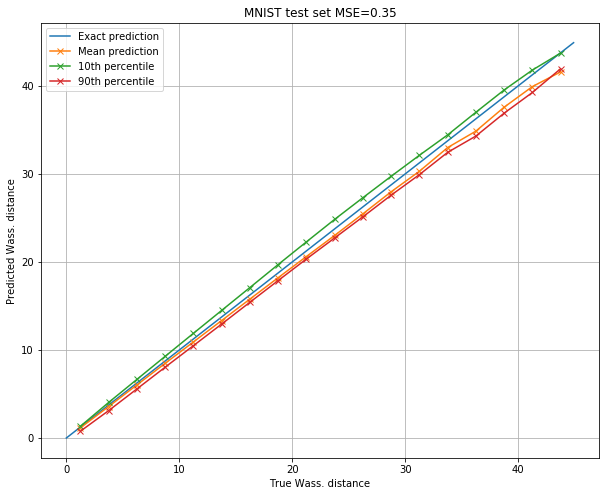

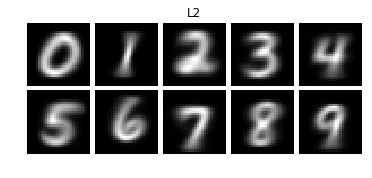

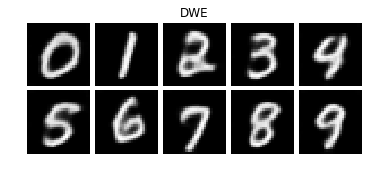

In [15]:
DST_CONFIG_DIR = 'mnist'
DST_BIG_DATA_DIR = '/pio/scratch/1/i233123/data_mnist'
LOG_FILE = 'stdout.txt'
CONFIG_FILE = 'config.txt'
    
#run_mnist(1000000, 0.001, 200, 1.0, True, True)
run_mnist(1000000, 0.001, 200, 1.0, True, False)

The neural network used above was being trained about 2 hours.

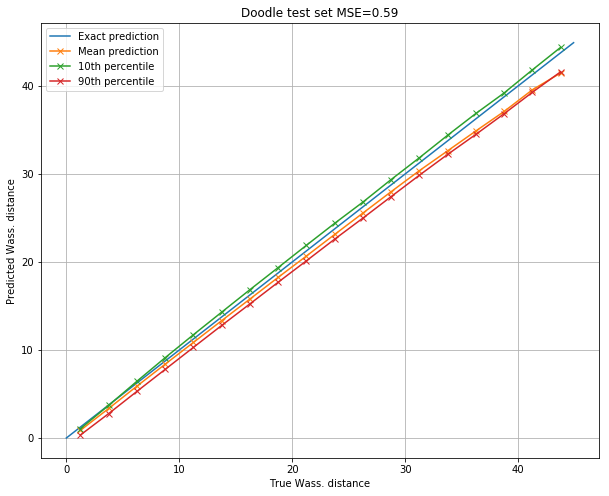

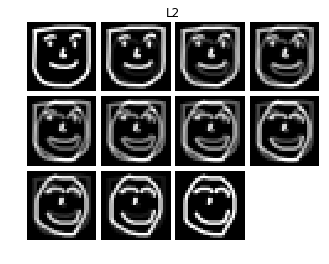

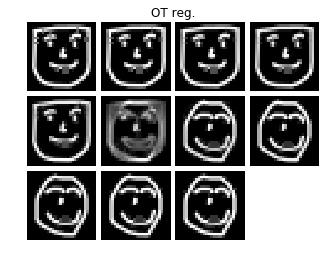

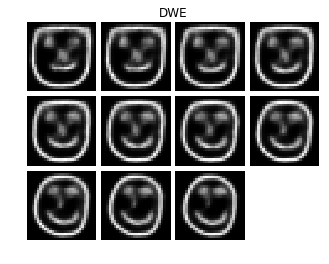

In [16]:
DST_CONFIG_DIR = 'doodle'
DST_BIG_DATA_DIR = '/pio/scratch/1/i233123/data_doodle'
LOG_FILE = 'stdout.txt'
CONFIG_FILE = 'config.txt'

#run_doodle(1000000, 0.0005, 4000, 1.0, True, True)
run_doodle(1000000, 0.0005, 200, 1.0, True, False)

The neural network used above was being trained about 2 hours.

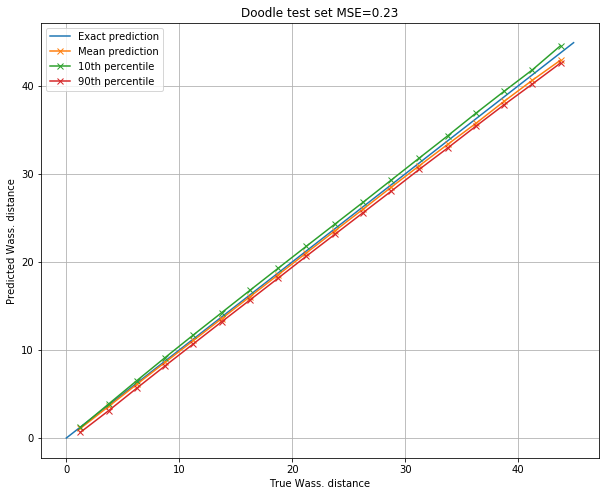

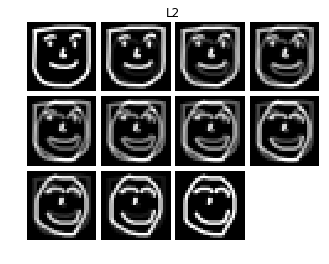

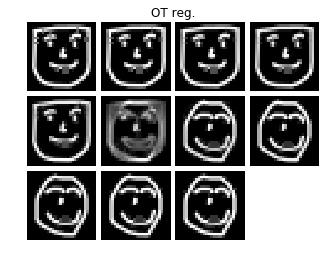

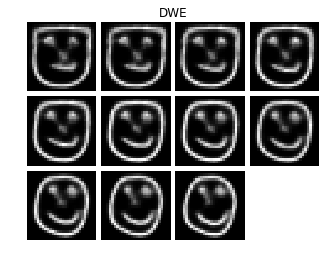

In [17]:
DST_CONFIG_DIR = 'doodle'
DST_BIG_DATA_DIR = '/pio/scratch/1/i233123/data_doodle'
LOG_FILE = 'stdout.txt'
CONFIG_FILE = 'config.txt'

#run_doodle(1000000, 0.0001, 4000, 1.0, True, True)
run_doodle(1000000, 0.0001, 200, 1.0, True, False)

The neural network used above was being trained about 2 days.